In [1]:
DATADIR = "SRCNN-Keras/yang91"
DATADIR2 = "SRCNN-Keras/yang91"

In [2]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
#from google.colab.patches import cv2_imshow
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input,Conv2DTranspose, add, Activation, LeakyReLU

In [3]:
scale = 2
req_size = 20
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
    readpath = os.path.join(DATADIR,filera)
    img = cv2.imread(readpath)
    img = np.asarray(img)
    shapes = img.shape
    for i in range(0, shapes[0]-req_size+1, stride):
        for j in range(0, shapes[1]-req_size+1,stride):
            subimage_HR = img[i:i+req_size, j:j+req_size]
            #cv2_imshow(subimage_HR)
            subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
            X.append(subimage_LR)
            labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
    counta=counta+1
    if(counta==300):
        break
        readpath = os.path.join(DATADIR2,filera)
        img = cv2.imread(readpath)
        img = np.asarray(img)
        shapes = img.shape
        for i in range(0, shapes[0]-req_size+1, stride):
            for j in range(0, shapes[1]-req_size+1,stride):
                subimage_HR = img[i:i+req_size, j:j+req_size]
                #cv2_imshow(subimage_HR)
                subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
                X.append(subimage_LR)
                labels.append(subimage_HR)

In [4]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(18849, 20, 20, 3)
(18849, 10, 10, 3)


In [5]:
alpha = 0.85
def basic_mse(y_true, y_pred):
    pred = tf.image.sobel_edges(y_pred)
    true = tf.image.sobel_edges(y_true)
    lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
    lossedge = tf.reduce_mean(tf.square(pred-true))
    return alpha*lossmse + (1-alpha)*lossedge

In [6]:
from tensorflow.keras import layers

In [53]:
def Upper_Branch(upscale_factor=2, channels=3):
    inputs = keras.Input(shape=(None, None, channels))
    C1 = layers.Conv2D(3, 3, padding = 'same')(inputs)
    L1 = LeakyReLU(alpha=0.2)(C1)
    C2 = layers.Conv2D(3, 3, padding = 'same')(L1)
    L2 = LeakyReLU(alpha=0.2)(C2)
    sum1 = add(inputs=[L1,L2])
    #D1 = Conv2DTranspose(3,(3,3), strides=(2,2),padding='same', activation='relu')(sum1)
    C3 = layers.Conv2D(3,32, padding = 'same')(sum1)
    L3 = LeakyReLU(alpha=0.2)(C3)
    #C4 = layers.Conv2D(3,3, padding = 'same')(L3)
    #L4 = LeakyReLU(alpha=0.2)(C4)
    model = Model(inputs= inputs, outputs=L3)
    return model

model = Upper_Branch()

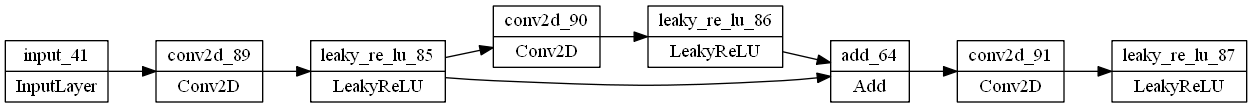

In [54]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [55]:
def SFEB_Block(upscale_factor=2, channels=3):
    inputs = keras.Input(shape=(None, None, channels))
    C1 = layers.Conv2D(3, 5, padding = 'same')(inputs)
    L1 = LeakyReLU(alpha=0.2)(C1)
    C2 = layers.Conv2D(3, 3, padding='same')(L1)
    sum2 = add(inputs=[inputs, C1,C2])
    #C4 = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same')(sum2)
    #outputs = tf.nn.depth_to_space(C4, upscale_factor)
    model = Model(inputs= inputs, outputs=sum2)
    return model

model = SFEB_Block()

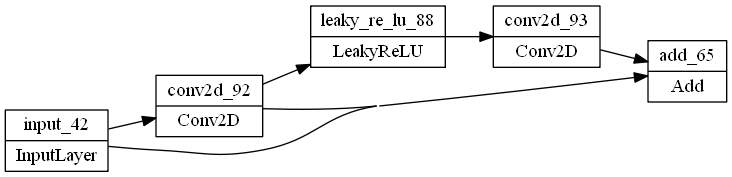

In [56]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [57]:
def CAB_Block(upscale_factor=2, channels=3):
    inputs = keras.Input(shape=(None, None, channels))
    C1 = layers.Conv2D(3, 1, padding = 'same')(inputs)
    L1 = LeakyReLU(alpha=0.2)(C1)
    sum1 = add(inputs=[inputs, L1])
    C2 = layers.Conv2D(1, 3, padding='same')(sum1)
    #C4 = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same')(sum2)
    #outputs = tf.nn.depth_to_space(C4, upscale_factor)
    model = Model(inputs= inputs, outputs=C2)
    return model

model = CAB_Block()

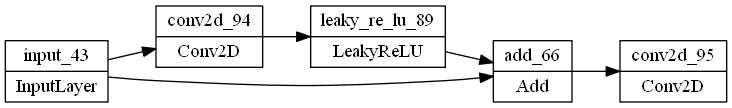

In [58]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [59]:
def SCUB_Block(upscale_factor=2, channels=3):
    inputs = keras.Input(shape=(None, None, channels))
    LA = LeakyReLU(alpha=0.2)(inputs)
    C1 = layers.Conv2D(64, 5, padding = 'same')(LA)
    L1 = LeakyReLU(alpha=0.2)(C1)
    C2 = layers.Conv2D(64, 3, padding='same')(LA)
    L2 = LeakyReLU(alpha=0.2)(C2)
    sum1 = add(inputs=[L1, L2])
    C3 = layers.Conv2D(3, 3, padding='same')(sum1)
    L3 = LeakyReLU(alpha=0.2)(C3)
    sum2 = add(inputs=[inputs, L3])
    #C4 = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same')(sum2)
    #outputs = tf.nn.depth_to_space(C4, upscale_factor)
    model = Model(inputs= inputs, outputs=sum2)
    return model

model = SCUB_Block()

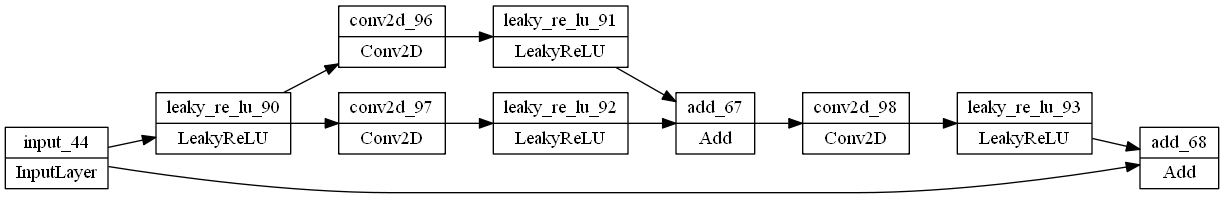

In [60]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [61]:
def SEB_Block(upscale_factor=2, channels=3):
    inputs = keras.Input(shape=(None, None, channels))
    #SQUEEZE STAGE
    PC1 = layers.Conv2D(32,(1,1),name='1x1_A',padding='SAME')(inputs)
    PC2 = layers.Conv2D(32,(1,1),name='1x1_B',padding='SAME')(inputs)
    PC3 = layers.Conv2D(32,(1,1),name='1x1_C',padding='SAME')(inputs)
    PC4 = layers.Conv2D(32,(1,1),name='1x1_D',padding='SAME')(inputs)
    Sum1 = add([PC1,PC2,PC3,PC4])
    PPC1 = LeakyReLU(alpha=0.2)(Sum1)
    
    #EXPAND STAGE
    PC5 = layers.Conv2D(32,(1,1),name='1x1_E',padding='SAME')(PPC1)
    DWC5  = layers.Conv2D(32,(3,3),name='3x3_A',padding='SAME')(PC5)
    
    PC6 = layers.Conv2D(32,(1,1),name='1x1_F',padding='SAME')(PPC1)
    DWC6  = layers.Conv2D(32,(3,3),name='3x3_B',padding='SAME')(PC6)
    
    PC7 = layers.Conv2D(32,(1,1),name='1x1_G',padding='SAME')(PPC1)
    DWC7  = layers.Conv2D(32,(3,3),name='3x3_C',padding='SAME')(PC7)
    
    PC8 = layers.Conv2D(32,(1,1),name='1x1_H',padding='SAME')(PPC1)
    DWC8  = layers.Conv2D(32,(3,3),name='3x3_D',padding='SAME')(PC8)
    
    PC9 = layers.Conv2D(32,(1,1),name='1x1_I',padding='SAME')(PPC1)
    DWC9  = layers.Conv2D(32,(3,3),name='3x3_E',padding='SAME')(PC9)
    
    PC10 = layers.Conv2D(32,(1,1),name='1x1J',padding='SAME')(PPC1)
    DWC10  = layers.Conv2D(32,(3,3),name='3x3_F',padding='SAME')(PC10)
    
    PC11 = layers.Conv2D(32,(1,1),name='1x1_K',padding='SAME')(PPC1)
    DWC11  = layers.Conv2D(32,(3,3),name='3x3_G',padding='SAME')(PC11)
    
    PC12 = layers.Conv2D(32,(1,1),name='1x1L',padding='SAME')(PPC1)
    DWC12  = layers.Conv2D(32,(3,3),name='3x3_H',padding='SAME')(PC12)
    
    Sum2  = add([DWC5,DWC6,DWC7,DWC8,DWC9,DWC10,DWC11,DWC12])
    PPC2 = LeakyReLU(alpha=0.2)(Sum2)
    #C4 = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same')(Sum2)
    #outputs = tf.nn.depth_to_space(C4, upscale_factor)
    model = Model(inputs= inputs, outputs=PPC2)
    return model

model = SEB_Block()

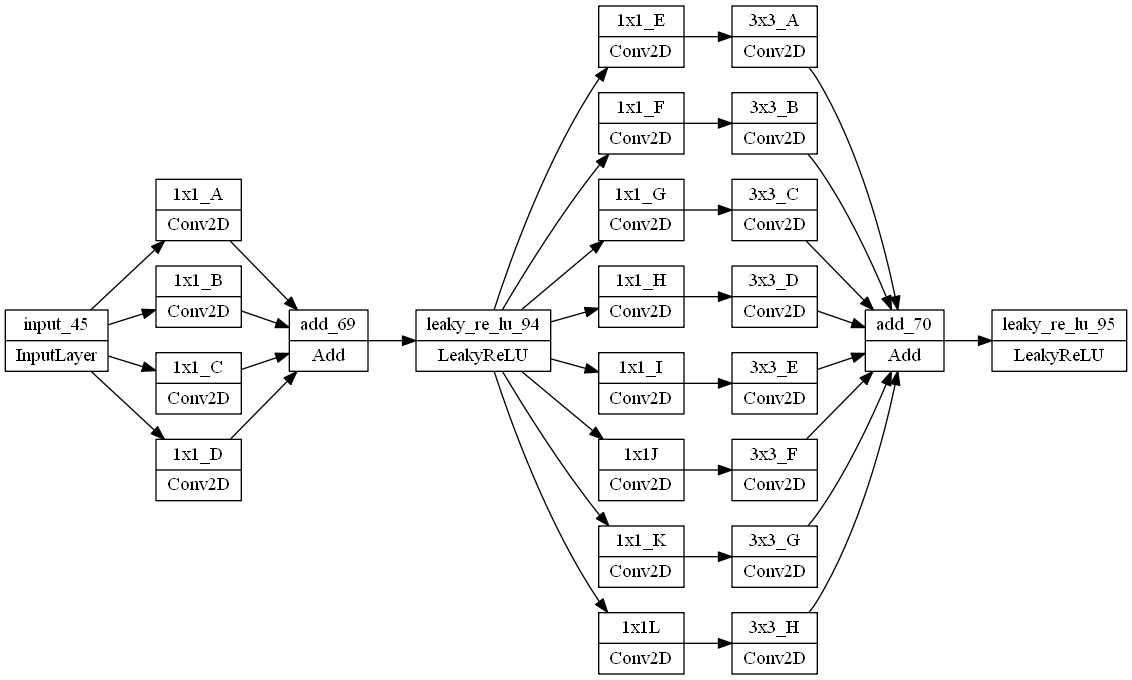

In [62]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [63]:
def SENext(upscale_factor=2, channels=3):
    inputs = keras.Input(shape=(None, None, channels))
    LA = LeakyReLU(alpha=0.2)(inputs)
    C11 = layers.Conv2D(3,1, padding = 'same',name='C11')(LA)
    SFEB1 = SFEB_Block()(C11)
    C111 = layers.Conv2D(3,1, padding = 'same',name='C111')(SFEB1)
    sum1  = add([inputs,C111])
    C22 = layers.Conv2D(3, 1, padding='same')(sum1)
    SEB1 = SEB_Block()(C22)
    C1111 = layers.Conv2D(3,1, padding = 'same',name='C1111')(SEB1)
    sum2  = add([inputs,C1111])
    C1 = layers.Conv2D(3, 1, padding='same')(sum2)
    SEB2 = SEB_Block()(C1)
    C11111 = layers.Conv2D(3,1, padding = 'same',name='C11111')(SEB2)
    sum3  = add([inputs,C11111])
    C2 = layers.Conv2D(3, 1, padding='same')(sum3)
    SEB3 = SEB_Block()(C2)
    C3 = layers.Conv2D(3, 1, padding='same')(SEB3)
    SCUB1 = SCUB_Block()(C3)
    C4 = layers.Conv2D(3, 1, padding='same')(SCUB1)
    CAB1 = CAB_Block()(C4)
    C5 = layers.Conv2D(3, 1, padding='same')(inputs)
    outputs1 = Upper_Branch()(C5)
    conc = keras.layers.concatenate([inputs,SFEB1,SEB1,SEB2,SEB3,outputs1], axis = -1)
    y = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same')(conc)
    outputs = tf.nn.depth_to_space(y, upscale_factor)
    Cout = layers.Conv2D(3, 1, padding='same')(outputs)
    model = Model(inputs= inputs, outputs=Cout)
    return model

model = SENext()

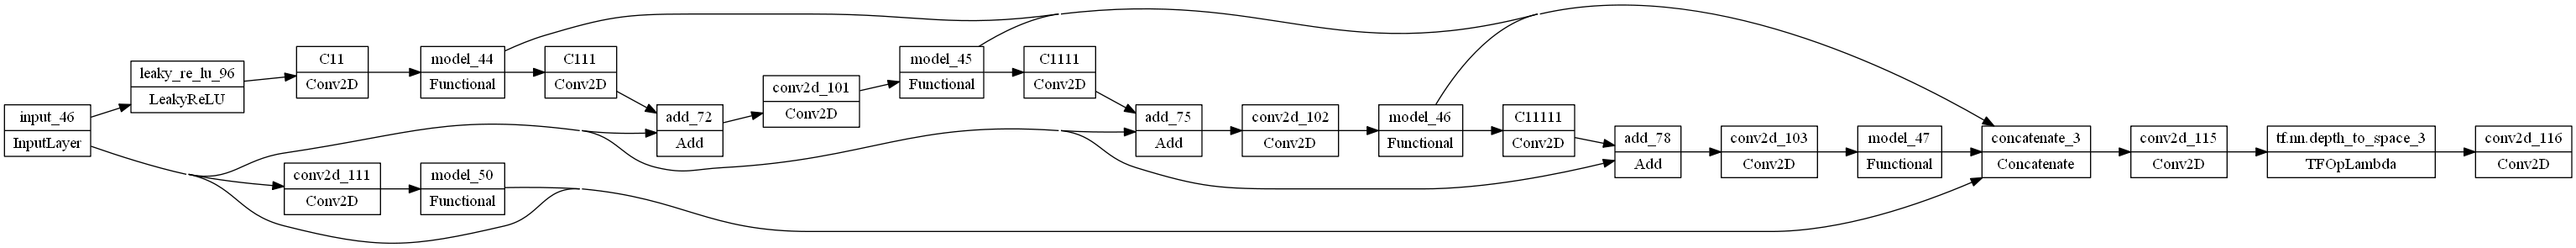

In [64]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [65]:
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

In [66]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [67]:
history = model.fit(X,labels,batch_size=32,shuffle=True,validation_split=0.01 ,epochs=5,verbose=1 )

Epoch 1/5
584/584 [==============================] - 26s 36ms/step - loss: 1328.6445 - accuracy: 0.8187 - val_loss: 108.1679 - val_accuracy: 0.9993: 0s - loss: 1380.7468 - a
Epoch 2/5
584/584 [==============================] - 21s 35ms/step - loss: 171.9875 - accuracy: 0.8985 - val_loss: 53.7853 - val_accuracy: 0.9997
Epoch 3/5
584/584 [==============================] - 21s 36ms/step - loss: 124.8868 - accuracy: 0.9213 - val_loss: 37.9894 - val_accuracy: 0.9998
Epoch 4/5
584/584 [==============================] - 22s 37ms/step - loss: 109.9353 - accuracy: 0.9314 - val_loss: 30.7339 - val_accuracy: 0.9999
Epoch 5/5
584/584 [==============================] - 23s 40ms/step - loss: 101.7786 - accuracy: 0.9365 - val_loss: 31.4582 - val_accuracy: 0.9999


In [68]:
def psnr_calc():
    testimg = []
    GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
    GT = np.asarray(GT)
    h = GT.shape[0]
    l = GT.shape[1]
    img1 = cv2.resize(GT,(int(l/2),int(h/2)),interpolation = cv2.INTER_CUBIC)
    img1 = np.asarray(img1)
    testimg.append(img1)
    testimg = np.asarray(testimg)
    print(testimg.shape)
    fin =(model.predict(testimg)[0])
    inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
    GT = GT[0:fin.shape[0],0:fin.shape[1],:]
    mse = np.square(np.subtract(GT, fin)).mean()
    #cv2_imshow(inp)
    #cv2_imshow(fin)
    #cv2_imshow(GT)
    import math
    psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
    return psnr

In [69]:
ps1 = psnr_calc()
print(ps1)

(1, 256, 256, 3)
22.917709321362807
